In [4]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
fpath='./vgg16-397923af.pth' # path for pretrained model
img_dir='./data/images'

In [6]:
class Adverdataset(Dataset):
    def __init__(self, root, labels, transforms):
        self.root=root # root prefix for pictures
        self.labels=torch.from_numpy(labels).long()
        self.transforms=transforms # from attacker,tailor pictures to the pretrained models
        self.findex=[]
        for i in range(200):
            self.findex.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # step1. open the picture
        img=Image.open(os.path.join(self.root, self.findex[idx] + '.png')) # join the absolute path
        # step2. transform the picture to certain format
        img=self.transforms(img)
        # step3. fetch its label
        label=self.labels[idx]
        return img,label
    
    def __len__(self):
        # 200 pictures totally
        return 200

In [7]:
class Attacker:
    def __init__(self, img_dir, label):
        # introduce vgg 16 and pretrained weight
        self.model=models.vgg16(pretrained=False)
        self.model.to(device)
        pre=torch.load(fpath,map_location=device)
        self.model.load_state_dict(pre) # load pretrained weight to the model
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # normalize to 0~1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        # compose transform
        transform=transforms.Compose([
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        # initialize dataset
        self.dataset=Adverdataset(img_dir, label, transform)
        # DataLoader is convenient for training and testing
        self.loader=torch.utils.data.DataLoader(
                    self.dataset,
                    batch_size=1,
                    shuffle=False
                    )
        
    # FGSM attack
    def fgsm_attack(self, image, epsilon, data_grad):
        # locate gradient
        sign_data_grad=data_grad.sign()
        # add noise in gradient direction
        delta_image=image+epsilon*sign_data_grad
        return delta_image
    
    def attack(self, epsilon):
        # save successful examples for attack
        examples=[]
        # wrong: initially predicted as a wrong class
        # fail: attack failed
        # success: attack succeeded
        wrong,fail,success=0,0,0
        for data,target in self.loader:
            data, target=data.to(device), target.to(device) # load on device
            data_raw=data # save initial picture
            data.requires_grad=True
            output=self.model(data) # use pretrained model to predict
            init_pred=output.max(1, keepdim=True)[1]
            # if wrong class, skip attacking
            if init_pred.item()!=target.item():
                wrong+=1
                continue
            # if correct class, start attacking
            loss=F.nll_loss(output, target)
            self.model.zero_grad()
            loss.backward()
            data_grad=data.grad.data
            delta_data=self.fgsm_attack(data,epsilon,data_grad) # use gradient to add disturbance
            
            # predict again
            new_output=self.model(delta_data)
            new_pred=new_output.max(1,keepdim=True)[1]
            # if still correct class, attack failed!
            if new_pred.item()==target.item():
                fail+=1
            else:
                # attack succeeded!
                success+=1
                # save attacked picture
                if len(examples)<5:
                    data_new=delta_data*torch.tensor(self.std,device=device).view(3,1,1)+torch.tensor(self.mean,device=device).view(3,1,1)
                    data_new=data_new.squeeze().detach().cpu().numpy() # change format
                    data_raw=data_raw*torch.tensor(self.std,device=device).view(3,1,1)+torch.tensor(self.mean,device=device).view(3,1,1)
                    data_raw=data_raw.squeeze().detach().cpu().numpy() # change format
                    examples.append((init_pred.item(),new_pred.item(), data_raw , data_new)) # save as a group of data
        final_acc=(fail/(fail+success+wrong))
        print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
        return examples,final_acc

In [8]:
if __name__=="__main__":
    label_df=pd.read_csv("./data/labels.csv")
    labels=label_df.loc[:,"TrueLabel"].values
    category_df=pd.read_csv('./data/categories.csv')
    categories=category_df.loc[:, 'CategoryName'].values
    # new an Attacker
    attacker=Attacker(img_dir,labels)
    epsilons = [0.1, 0.01]
    all_accuracy=[]
    all_examples=[]
    for eps in epsilons:
        accuracy,examples=attacker.attack(eps)
        all_examples.append(accuracy)
        all_accuracy.append(examples)

Epsilon: 0.1	Test Accuracy = 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy = 54 / 200 = 0.27



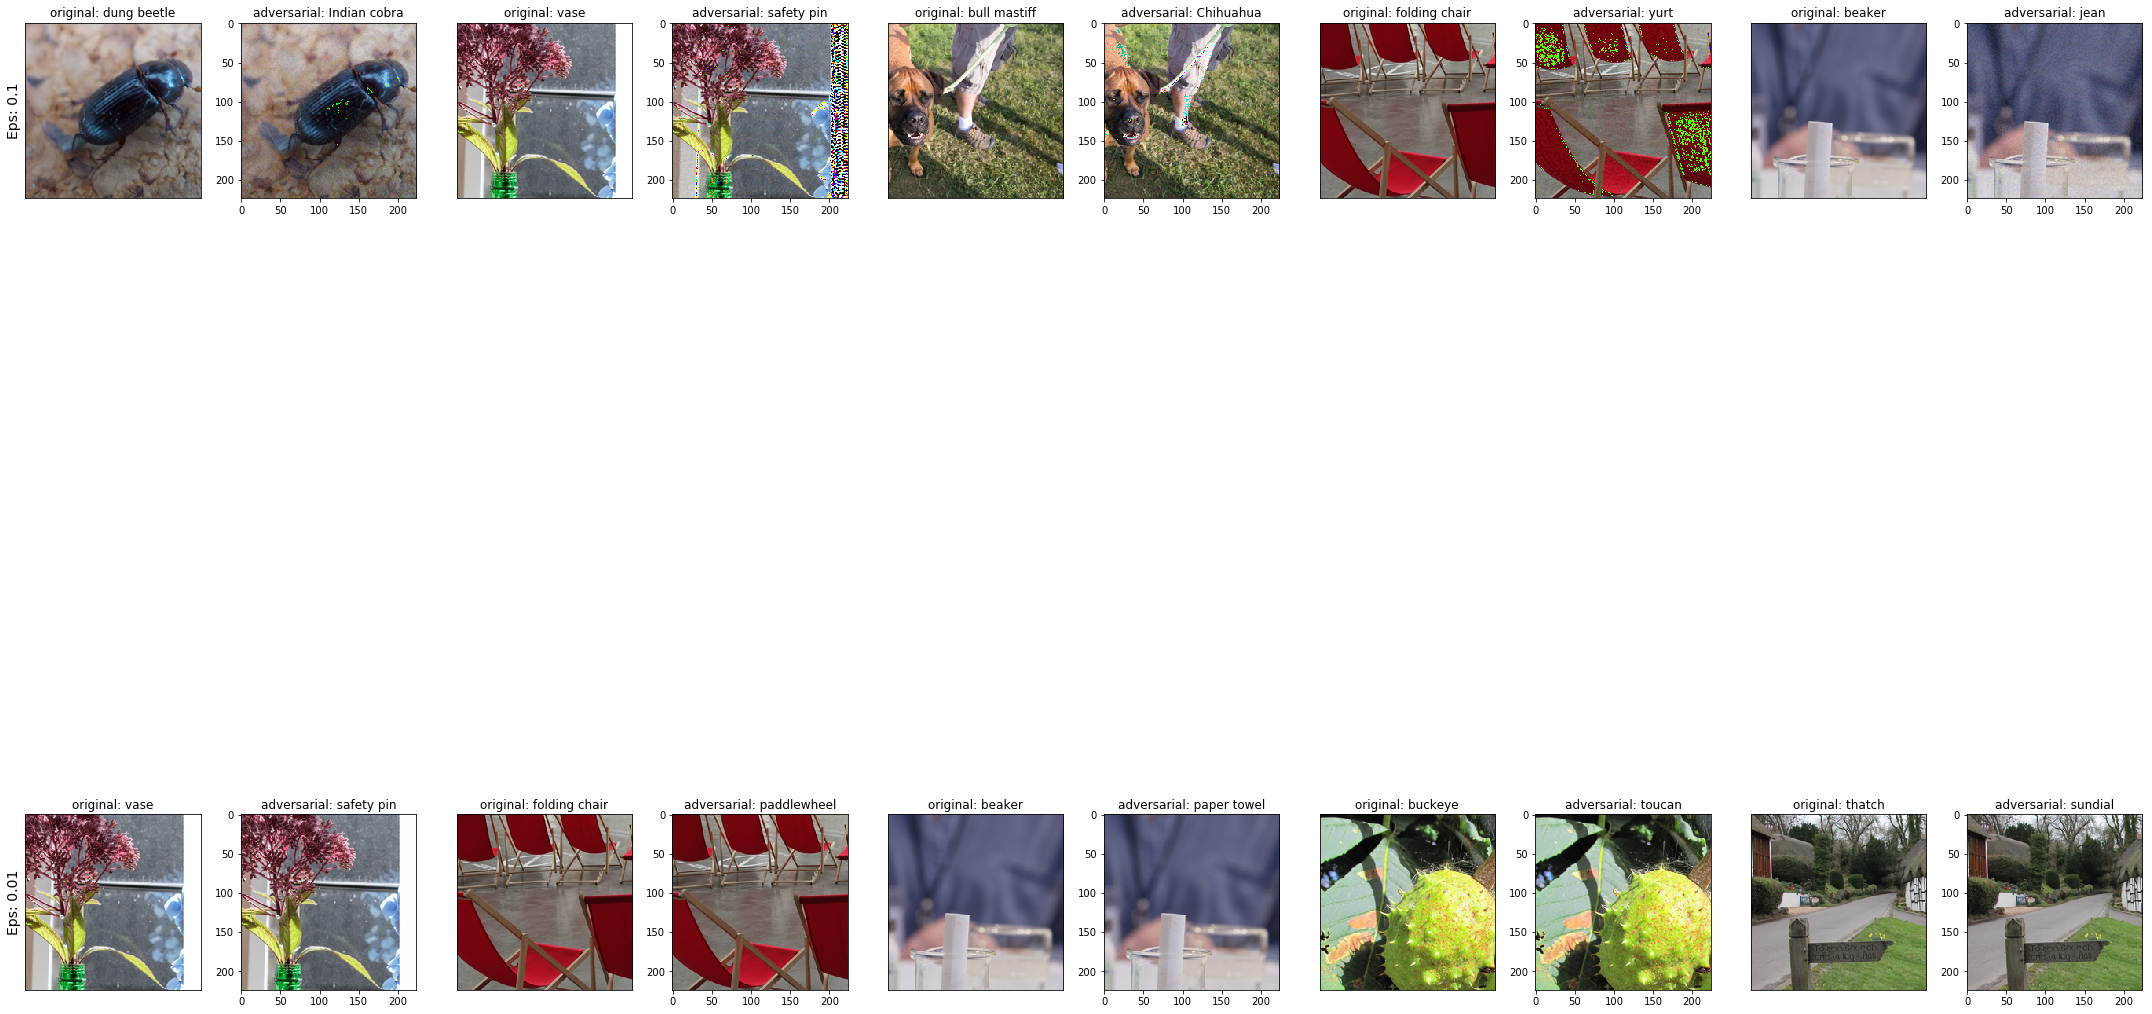

In [9]:
# show example pictures
cnt = 0
plt.figure(figsize=(30, 30))
# for every epsilon group
for i in range(len(epsilons)):
    # for every group of example
    for j in range(len(all_examples[i])):
        cnt+=1
        plt.subplot(len(epsilons),len(all_examples[0]) * 2,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)# label for the epsilon group
        ori_pred,new_pred,ori_img, new_img = all_examples[i][j]
        # plt.title("{} -> {}".format(ori, new)
        plt.title("original: {}".format(categories[ori_pred].split(',')[0]))
        ori_img = np.transpose(ori_img, (1, 2, 0))
        plt.imshow(ori_img)
        cnt+=1
        plt.subplot(len(epsilons),len(all_examples[0]) * 2,cnt)
        plt.title("adversarial: {}".format(categories[new_pred].split(',')[0]))
        new_img = np.transpose(new_img, (1, 2, 0))
        plt.imshow(new_img)
plt.tight_layout()
plt.show()